# 2D obstacle problem with dG formulation

We consider the unsteady Navier-Stokes problem defined by the following set of differential equations: 

$$
\begin{cases}
  \frac{\partial \boldsymbol{u}}{\partial t} 
  -\mu\boldsymbol{\Delta} \boldsymbol{u} + \boldsymbol{\nabla} p = 0, 
  \qquad&\text{in }\Omega\times I, \\
  \boldsymbol{\nabla} \cdot \boldsymbol{u} = 0, 
  \qquad &\text{in }\Omega\times I, \\
  \boldsymbol{u} = (1-y^2) \boldsymbol{i}, \qquad&\text{on }(\Gamma_{\text{in}} := \{x= -1,\, -1\le y \le 1 \})\times I, \\
  \left(\mu\boldsymbol{\nabla} \boldsymbol{u} - pI\right) \boldsymbol{n} = 0, \qquad&\text{on }(\Gamma_{\text{out}} := \{x=4,\, -1\le y \le 1\})\times I, \\
  \boldsymbol{u} = \boldsymbol{0}, \qquad&\text{on }\partial\Omega \backslash (\Gamma_{\text{in}}\cup\Gamma_{\text{out}}) \times I, \\
  \boldsymbol{u}(\cdot,t=0) = \boldsymbol{0}, &\text{in }\Omega,
\end{cases}
$$

where $\mu = 2.0$, the time interval is $I=(0,40)$, and the spatial domain $\Omega$ is described as follows.

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

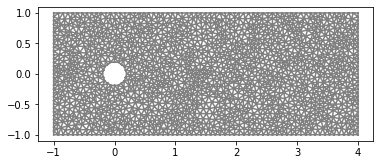

In [6]:
# Geometry and mesh 
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 40
mesh = generate_mesh(geometry, n)
plot(mesh)

## Numerical solution with dG (primal formulation)

In [39]:
# 1. mesh generation
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 60
mesh = generate_mesh(geometry, n)

# 2. finite element space and BCs
deg = 2
V = VectorElement('DG', mesh.ufl_cell(), deg)
Q = FiniteElement('DG', mesh.ufl_cell(), deg-1)
X = FunctionSpace(mesh, V * Q)

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class inflow_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], -1.0)

class rigid_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and not near(x[0], -1.0) and not near(x[0], 4.0)

u_inflow = Expression(('t*(1 - x[1] * x[1])', '0'), degree=2, t=0.0)

inflow = inflow_bnd()
inflow.mark(boundary_markers, 1)
rigid = rigid_bnd()
rigid.mark(boundary_markers, 2)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

After introducing the FE spaces and defining the boundary conditions, we proceed with the formulation of the discrete problem corresponding to the implicit Euler time-advancing scheme (with a time-step $\delta t = 0.5$).

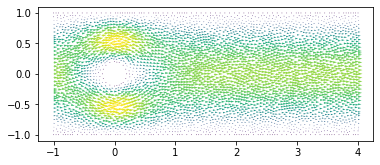

In [49]:
# 3. problem definition
u, p = TrialFunctions(X)
v, q = TestFunctions(X)

x_old = Function(X)
u_old, p_old = split(x_old)

mu = Constant(2.0)
time = 0.0
dt = 0.25
n = FacetNormal(mesh)
h = CellDiameter(mesh)
h_avg = (h('+') + h('-'))/2
alpha = 10.1*mu*deg**2
beta = 1.1/deg
    
a = (dot(u, v)/Constant(dt))*dx  \
  + (mu*inner(grad(u), grad(v)) - p*div(v) + div(u)*q)*dx  \
  - inner(jump(u, n), avg(q))*dS + inner(jump(v, n), avg(p))*dS \
  - inner(u, n)*q*ds(1) - inner(u, n)*q*ds(2) + inner(v, n)*p*ds(2) \
  - inner(dot(avg(mu*grad(u)), n('+')), jump(v))*dS - inner(jump(u), dot(mu*avg(grad(v)), n('+')))*dS \
  - inner(u, dot(mu*grad(v), n))*ds(1) - inner(dot(mu*grad(u), n), v)*ds(2) - inner(u, dot(mu*grad(v), n))*ds(2) \
  + alpha/h_avg*inner(jump(u), jump(v))*dS + alpha/h*inner(u, v)*(ds(1)+ds(2)) \
  + beta*h_avg*jump(p)*jump(q)*dS 

L = (dot(u_old, v)/Constant(dt))*dx - (inner(u_inflow, n)*q+inner(u_inflow, dot(mu*grad(v), n))-alpha/h*inner(u_inflow, v))*ds(1)

#4. solve (advance in time)
A = assemble(a)
Ainv = LUSolver(A)

while time < 40.0:
    time += dt
    u_inflow.t = time
        
    b = assemble(L)
    Ainv.solve(x_old.vector(), b)
    u_old, p_old = x_old.split()

# plot the final velocity field     
plot(u_old)

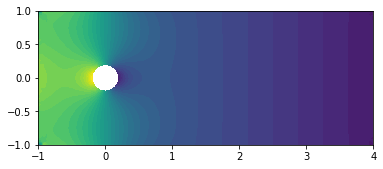

In [41]:
# plot the final pressure  
plot(p_old)

## Numerical solution with dG (pseudo-stress formulation)

In [46]:
# 2b. finite element space and BCs
deg = 2
S = TensorFunctionSpace(mesh, 'DG', deg)

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class inflow_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], -1.0)

class outflow_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 4.0)

# this corresponds to the acceleration at Dirichlet bnd
u_inflow = Expression(('(1 - x[1] * x[1])', '0'), degree=2, t=0.0)

inflow = inflow_bnd()
inflow.mark(boundary_markers, 1)
outflow = rigid_bnd()
outflow.mark(boundary_markers, 2)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

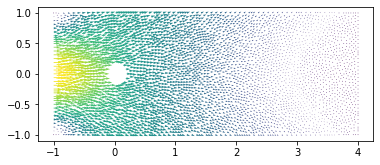

In [47]:
# 3b. problem definition
s = TrialFunction(S)
r = TestFunction(S)
s_old = Function(S)

mu = Constant(2.0)
time = 0.0
dt = 0.25
n = FacetNormal(mesh)
h = CellDiameter(mesh)
h_avg = (h('+') + h('-'))/2
alpha = 10.1*mu*deg**2

a = inner(dev(s), dev(r))/(mu*Constant(dt)) * dx + dot(div(s), div(r)) * dx  \
  - dot(avg(div(s)), jump(r, n)) * dS - dot(jump(s, n), avg(div(r))) * dS \
  - dot(div(s), dot(r, n)) * ds(2) - dot(dot(s, n), div(r)) * ds(2) \
  + alpha/h_avg * dot(jump(s, n), jump(r, n)) * dS \
  + alpha/h*dot(dot(s, n), dot(r, n)) * ds(2)  

L = inner(dev(s_old), dev(r))/(mu*Constant(dt))*dx + dot(u_inflow, dot(r, n))*ds(1)

#4. solve (advance in time)
A = assemble(a)
Ainv = LUSolver(A)
s = Function(S)

while time < 40.0:
    time += dt
    u_inflow.t = time
        
    b = assemble(L)
    s_old.assign(s)
    Ainv.solve(s.vector(), b)

# plot the final acceleration field   
plot(div(s)) 

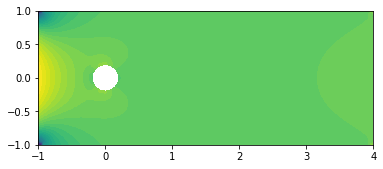

In [48]:
# plot the final pressure   
plot(-0.5*tr(s)) 